In [41]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.gridspec as gridspec
from BSE import Exchange

from BSE import market_session
from BSE import populate_market
from BSE import customer_orders

In [42]:
import os
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

from BSE import Exchange, market_session, populate_market, customer_orders

In [43]:
# === Trader Class (Tracks Initial Balance for Profit Calculation) ===
class Trader:
    def __init__(self, ttype, tid, balance, params, time):
        self.ttype = ttype
        self.tid = tid
        self.balance = balance
        self.initial_balance = balance  # Store starting balance
        self.orders = []
        self.blotter = []
        self.n_trades = 0

    def bookkeep(self, trade, order, verbose, time):
        transaction_price = trade['price']
        if order.otype == 'Bid':  # Buying
            profit = order.price - transaction_price
        else:  # Selling
            profit = transaction_price - order.price

        self.balance += profit  # Update balance
        self.n_trades += 1

        if verbose:
            print(f"{self.tid}: Profit={profit}, Balance={self.balance}")

# === Function to Run a Single Market Session ===
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump):
    """Runs a market session and logs data."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        # Log trader statistics
        lob = exchange.publish_lob(time, None, verbose=verbose)
        write_trade_stats(sess_id, traders, tdump, time, lob)

        time += timestep

# === Function to Log Trader Statistics in CSV ===
def write_trade_stats(expid, traders, tdump, time, lob):
    trader_types = {}

    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        balance = trader.balance
        profit = balance - trader.initial_balance  # Corrected profit calculation

        # Track statistics for each trader type
        if ttype in trader_types:
            trader_types[ttype]['balance_sum'] += balance
            trader_types[ttype]['profit_sum'] += profit 
            trader_types[ttype]['n'] += 1
        else:
            trader_types[ttype] = {'balance_sum': balance, 'profit_sum': profit, 'n': 1}

    # Write results to CSV
    for ttype, stats in trader_types.items():
        avg_profit = stats['profit_sum'] / stats['n']
        profit_type = "Positive" if stats['profit_sum'] >= 0 else "Negative"

        tdump.write(
            f"{expid},{time},{lob['bids']['best']},{lob['asks']['best']},"
            f"{ttype},{stats['balance_sum']},{stats['profit_sum']},{profit_type}\n"
        )




In [44]:
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

from BSE import Exchange, market_session, populate_market, customer_orders

# ... (the rest of your existing imports and code) ...

def run_multiple_sessions_with_different_trader_counts():
    # Define time parameters
    end_time = 60 * 5  # 2 minutes simulation time

    # We'll run sessions for each of these trader-counts
    trader_counts = [1, 2, 5, 10]

    output_file = 'bigtestdata.csv'
    with open(output_file, 'w') as tdump:
        # Write CSV header once
        tdump.write("Trial,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType\n")

        for trial_idx, count in enumerate(trader_counts, start=1):
            # Build a session ID
            session_id = f"session_{count}Traders"
            print(f"\nRunning session {session_id} with {count} traders per type...")

            # Build the traders_spec for this session
            # For example, if you originally had 1 of each type, multiply by 'count'
            # You can adapt the ratio of each type as you see fit:
            traders_spec = {
                'buyers': [
                    ('ZIC', count),
                    ('MarketMaker', count),
                    ('GVWY', count),
                    ('SHVR', count),
                    ('ZIP', count)
                ],
                'sellers': [
                    ('ZIC', count),
                    ('MarketMaker', count),
                    ('GVWY', count),
                    ('SHVR', count),
                    ('ZIP', count)
                ],
            }

            # Define the order schedule (unchanged from your code)
            order_schedule = {
                'sup': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
                'dem': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
                'timemode': 'drip-poisson',
                'interval': 0.1,
            }

            # Run the market session
            market_session_with_logging(
                sess_id=session_id,
                starttime=0.0,
                endtime=end_time,
                traders_spec=traders_spec,
                order_schedule=order_schedule,
                dump_flags={
                    'dump_tape': False, 'dump_strats': False,
                    'dump_lobs': False, 'dump_blotters': False,
                    'dump_avgbals': False,
                },
                verbose=False,
                tdump=tdump  # same CSV for all sessions
            )

    print(f"\nAll sessions complete. Results saved to {output_file}.")

# Finally, call the function to run everything
if __name__ == "__main__":
    run_multiple_sessions_with_different_trader_counts()



Running session session_1Traders with 1 traders per type...

Running session session_2Traders with 2 traders per type...

Running session session_5Traders with 5 traders per type...

Running session session_10Traders with 10 traders per type...

All sessions complete. Results saved to bigtestdata.csv.


/var/folders/x7/vjyxn4513wgcl1bqzb17849r0000gn/T/ipykernel_2970/56391060.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("bigtestdata.csv")
/var/folders/x7/vjyxn4513wgcl1bqzb17849r0000gn/T/ipykernel_2970/56391060.py:19: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("bigtestdata.csv")


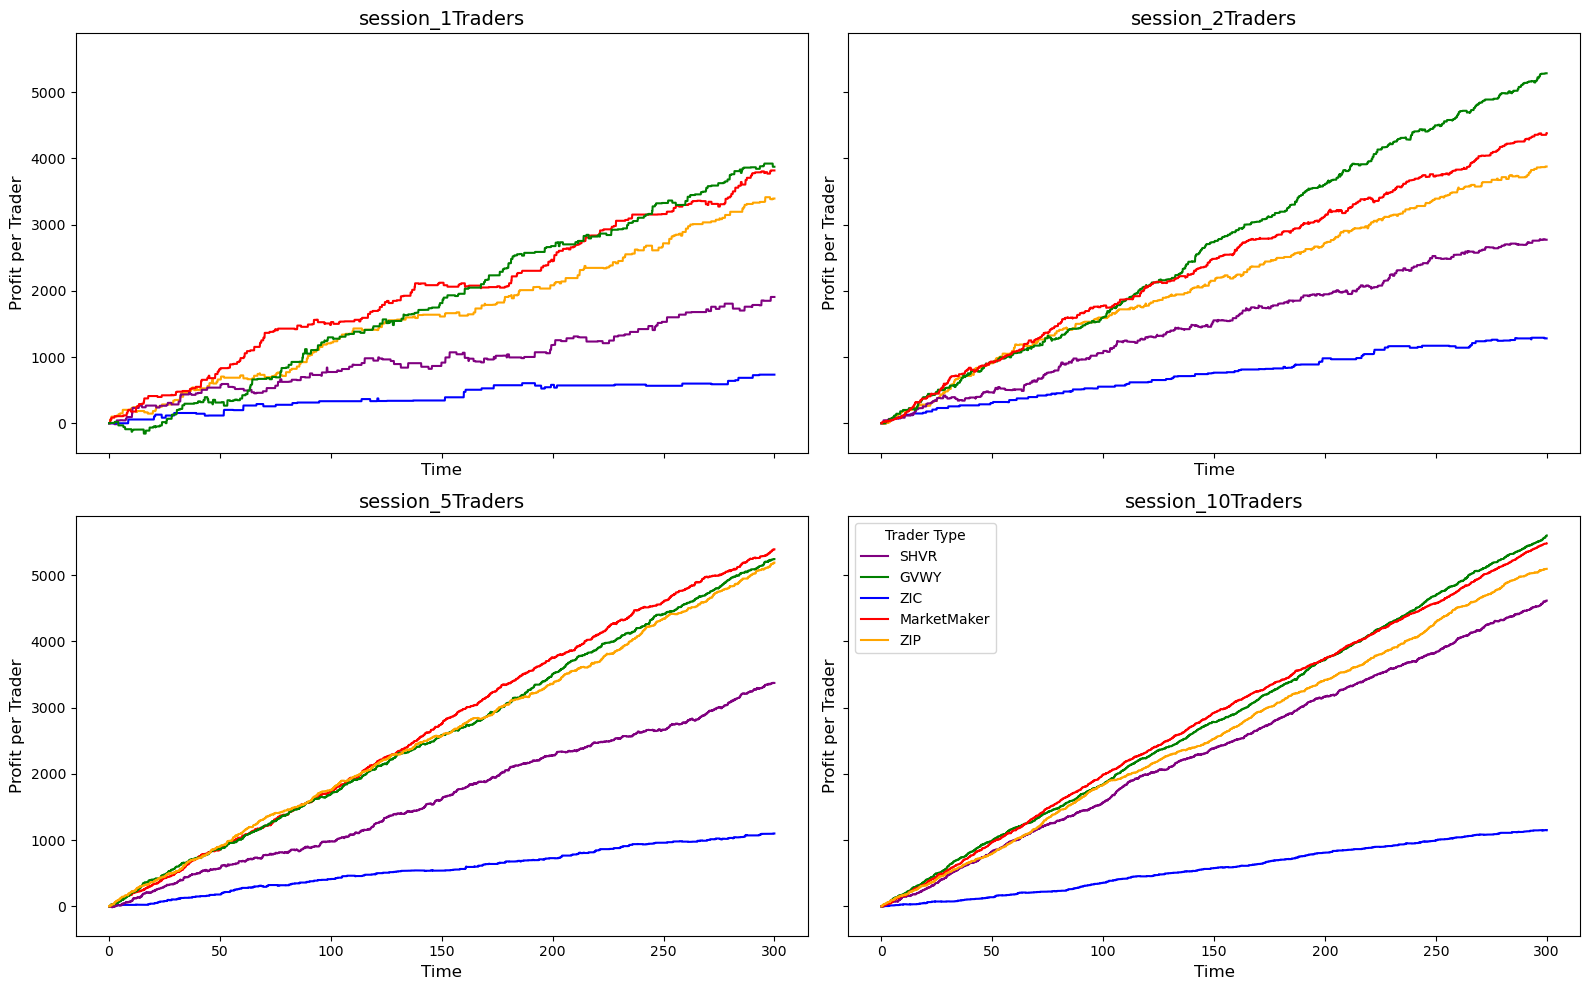

In [45]:
df = pd.read_csv("bigtestdata.csv")
import pandas as pd
import matplotlib.pyplot as plt
import re

def parse_trader_count(trial_str):
    """
    Given a string like 'session_10Traders', 
    extract '10' and return it as an integer.
    """
    match = re.search(r'session_(\d+)Traders', trial_str)
    if match:
        return int(match.group(1))
    return 1  # default fallback

trials = sorted(df['Trial'].unique(), key=parse_trader_count)

# 1) Read CSV
df = pd.read_csv("bigtestdata.csv")

# 2) Create a column 'TraderCount' by parsing the 'Trial' string
df['TraderCount'] = df['Trial'].apply(parse_trader_count)

# 3) Compute 'ProfitPerTrader' by dividing 'TotalProfit' by 'TraderCount'
df['ProfitPerTrader'] = df['TotalProfit'] / df['TraderCount']

# Dictionary mapping each trader type to a specific color
trader_colors = {
    'ZIC': 'blue',
    'MarketMaker': 'red',
    'GVWY': 'green',
    'SHVR': 'purple',
    'ZIP': 'orange'
    # Add more if needed
}

# 4) Sort trials by the number of traders
trials = sorted(df['Trial'].unique(), key=parse_trader_count)
# Create a 2x2 grid of subplots. In row-major order, the first subplot is top left,
# second is top right, third is bottom left, and fourth is bottom right.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, trial in zip(axes, trials):
    # Filter to the current session
    df_trial = df[df['Trial'] == trial].copy()
    df_trial.sort_values('Time', inplace=True)

    # Get each TraderType
    trader_types = df_trial['TraderType'].unique()

    # Plot each type's profit per trader over time using fixed colors
    for ttype in trader_types:
        df_type = df_trial[df_trial['TraderType'] == ttype]
        color = trader_colors.get(ttype, 'black')  # Use fixed color
        ax.plot(df_type['Time'], df_type['ProfitPerTrader'],
                linestyle='-', color=color, label=ttype)
    
    ax.set_title(trial, fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Profit per Trader", fontsize=12)

ax.legend(title="Trader Type", fontsize=10)

plt.tight_layout()
plt.show()
